In [265]:
#import standard libraries
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#for plots
import matplotlib.pyplot as plt
import seaborn as sns

#import html/scraping libraries
import requests
from bs4 import BeautifulSoup
import json
from pandas.io.json import json_normalize

#import mapping libraries
import geopy
import folium
from geopy.geocoders import Nominatim
from IPython.display import Image

#import colors
import matplotlib.cm as cm
import matplotlib.colors as colors



In [2]:
#Uncomment to dl
'''#download portland geojson
!wget -q -O 'pdx_data.geojson' https://opendata.arcgis.com/datasets/9f50a605cf4945259b983fa35c993fe9_125.geojson'''

"#download portland geojson\n!wget -q -O 'pdx_data.geojson' https://opendata.arcgis.com/datasets/9f50a605cf4945259b983fa35c993fe9_125.geojson"

In [3]:
with open('pdx_data.geojson') as f:
    pdx_geo = json.load(f)

We can look at what kind of data we have:

In [4]:
pdx_geo['features'][4]

{'type': 'Feature',
 'properties': {'OBJECTID': 5,
  'NAME': 'CULLY ASSOCIATION OF NEIGHBORS',
  'COMMPLAN': ' ',
  'SHARED': ' ',
  'COALIT': 'CNN',
  'HORZ_VERT': 'HORZ',
  'MAPLABEL': 'Cully Association of Neighbors',
  'ID': 23,
  'Shape_Length': 18179.392090202025,
  'Shape_Area': 16580624.669252962},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-122.6147122245439, 45.54829038307215],
    [-122.60785446051207, 45.548264575609245],
    [-122.59938743920893, 45.54822488960527],
    [-122.59938092282987, 45.54857652975009],
    [-122.59937739514577, 45.54885060900733],
    [-122.59937020323359, 45.54928954232259],
    [-122.59936472979857, 45.54956382821686],
    [-122.5993575315982, 45.550002589256856],
    [-122.59935401020228, 45.550276840846834],
    [-122.59934741746642, 45.55062642430259],
    [-122.59934328880935, 45.550989851980546],
    [-122.59933472966135, 45.55149739922728],
    [-122.59933165023655, 45.551730830835176],
    [-122.5993316547281, 45.55246988194597]

We need additional data for this project, I have downloaded data from portlandmap.com also, I am scraping data from 2019 from a site that seems to have the most up to date data for population statistics by neighborhood

In [5]:
permits_df = pd.read_csv('Residential_Building_Permits.csv')
#lets look at the time frame of the permits
print('Date Range : {} to {}'.format(min(permits_df['YEAR_']),max(permits_df['YEAR_'])))
print('Size of the data: {}'.format(permits_df.shape))

Date Range : 1994 to 2019
Size of the data: (30106, 28)


Lets narrow the data down to 2016-present and see what kind of permits we are dealing with

In [6]:
permits_df = permits_df[permits_df['YEAR_'] >= 2016]
print(permits_df.shape)
permits_df.NEWCLASS.unique()

(5527, 28)


array(['New Construction', 'Alteration', 'Move', 'Addition',
       'Replacement', 'First'], dtype=object)

With the objective of estimating new residents, we will only keep the 'Addition' and "New Construction" values.

In [7]:
permits_df = permits_df[permits_df['NEWCLASS'].isin(['New Construction','Addition'])]
permits_df.shape


(4689, 28)

In [8]:
permits_df.head()

X          Y  OBJECTID                    INDATE  \
23336 -122.771014  45.720797     23337  2013-03-06T00:00:00.000Z   
23338 -122.588079  45.562411     23339  2013-04-05T00:00:00.000Z   
23339 -122.588340  45.562319     23340  2013-04-05T00:00:00.000Z   
23344 -122.568927  45.527362     23345  2013-06-28T00:00:00.000Z   
23345 -122.568927  45.527281     23346  2013-06-28T00:00:00.000Z   

                      ISSUEDATE      STATUS  YEAR_          NEWCLASS  \
23336  2016-07-15T15:39:49.000Z  Admin Hold   2016  New Construction   
23338  2017-06-16T09:49:52.000Z      Issued   2017  New Construction   
23339  2017-06-16T09:50:06.000Z      Issued   2017  New Construction   
23344  2017-03-17T08:22:36.000Z       Final   2017  New Construction   
23345  2017-03-14T08:32:13.000Z       Final   2017  New Construction   

                      NEWTYPE                         NBRHOOD  ... NEW_UNITS  \
23336  Single Family Dwelling                             NaN  ...         1   
23338       Apartments/Condos  CULLY ASSOCIATION OF NEIGHBORS  ...        12   
23339       Apartments/Condos  CULLY ASSOCIATION OF NEIGHBORS  ...        12   
23344               Townhouse                      MONTAVILLA  ...         1   
23345               Townhouse                      MONTAVILLA  ...         1   

                                              FOLDER_DES VALUATION CONST  \
23336  NEW SINGLE FAMILY RESIDENCE/2 STORY/2 CAR GARA...    912966   V-B   
23338  NEW 12 UNIT THREE STORY APARTMENT BUILDING AND...   1112998   V-B   
23339  NEW 12 UNIT THREE STORY APARTMENT BUILDING, me...   1112998   V-B   
23344  UNIT 1 OF 5 UNIT TOWHOUSE - ALL ON SAME TAX LO...    200112   V-B   
23345  UNIT 2 OF 5 UNIT TOWHOUSE - ALL ON SAME TAX LO...    210687   V-B   

       PROPLOT      PROPGISID1       PROPERTYRO FOLDERRSN       X_COORD  \
23336  R502908   3N1W23    700  3N1W23    00700   3283314  7.622136e+06   
23338  R209993  1N2E20AB  4900  1N2E20AB  04900   3296117  7.667349e+06   
23339  R209993  1N2E20AB  4900  1N2E20AB  04900   3296123  7.667282e+06   
23344  R498064  1N2E33BD  2901  1N2E33BD  02901   3333750  7.671926e+06   
23345  R498064  1N2E33BD  2901  1N2E33BD  02901   3333757  7.671925e+06   

             Y_COORD  
23336  757041.415376  
23338  698049.685919  
23339  698017.793594  
23344  685148.493545  
23345  685118.964405  

[5 rows x 28 columns]

Now we need to keep only entries that have a neighborhood assignment

In [9]:
permits_df = permits_df[permits_df['NBRHOOD'].notnull()]
permits_df.shape,len(permits_df.NBRHOOD.unique())

((4663, 28), 105)

It looks like we have 105 unique neighborhoods, with 4663 building permits in identified neighborhoods.

Lets continue to get some more data.


In [10]:
pdxdata_url = 'https://www.pdxmonthly.com/home-and-real-estate/2019/03/portland-neighborhoods-by-the-numbers-2019-the-city'
pdx_soup = BeautifulSoup(requests.get(pdxdata_url).text,'lxml')

In [11]:
#get a list of columns
col_names = [i.text for i in pdx_soup.find_all('th')]
#extraxt each datapoint for each row in the table
by_hood = [[entry.text for entry in row.find_all('td')]for row in pdx_soup.find_all('tr')[1:]]

In [12]:
pdx_hood_df = pd.DataFrame(columns=col_names, data=by_hood)

In [13]:
pdx_hood_df[pdx_hood_df['Neighborhood'] == 'PORTLAND TOTAL**']

Neighborhood Average home sale price ($) Median home sale price ($)  \
95  PORTLAND TOTAL**                     480,268                    420,000   

   Average cost per square foot ($) Days on market (avg.)  \
95                              255                    37   

   Homes sold in 2018 (#) Condo sales (%)  \
95                  9,427             17%   

   1-year median price change (2017–2018) (%)  \
95                                         5%   

   5-year median price change (2014–2018) (%) Distressed property sales (%)  \
95                                        35%                            1%   

    ... Commute by public transit (%) Commute by bike (%)  \
95  ...                          12.3                 6.5   

   Commute by walking (%) Commute by biking and walking (%)  \
95                    5.7                              12.2   

   Number of Max/streetcar/tram lines Number of TriMet bus lines  \
95                                  8                         57   

   Number of transit lines (bus/MAX/streetcar/tram)  \
95                                               79   

   Miles of bike routes (lanes, boulevards, multiuse paths)  \
95                                                469         

   Miles of bike routes (all) per square mile Walk score  
95                                        3.2         65  

[1 rows x 57 columns]

In [14]:
pdx_hood_df.drop(pdx_hood_df.index[95], inplace=True)
print(pdx_hood_df.shape)

pdx_hood_df.head()

(95, 57)


Neighborhood Average home sale price ($)  \
0                  ALAMEDA                     785,713   
1              ARBOR LODGE                     465,743   
2  ARDENWALD-JOHNSON CREEK                     418,640   
3                    ARGAY                     391,146   
4        ARLINGTON HEIGHTS                   1,012,913   

  Median home sale price ($) Average cost per square foot ($)  \
0                    738,000                              268   
1                    459,450                              252   
2                    434,500                              185   
3                    399,750                              168   
4                    862,500                              306   

  Days on market (avg.) Homes sold in 2018 (#) Condo sales (%)  \
0                    31                     81              0%   
1                    28                    132             13%   
2                    89                     10              0%   
3                    26                     79              5%   
4                    49                     20              0%   

  1-year median price change (2017–2018) (%)  \
0                                         8%   
1                                         1%   
2                                        -7%   
3                                        11%   
4                                        -6%   

  5-year median price change (2014–2018) (%) Distressed property sales (%)  \
0                                        26%                            1%   
1                                        33%                            0%   
2                                        34%                           10%   
3                                        52%                            0%   
4                                         9%                            0%   

   ... Commute by public transit (%) Commute by bike (%)  \
0  ...                           8.8                 3.9   
1  ...                          14.2                 3.6   
2  ...                           9.3                 0.4   
3  ...                           8.6                15.8   
4  ...                             6                10.6   

  Commute by walking (%) Commute by biking and walking (%)  \
0                     11                              14.9   
1                   11.9                              15.6   
2                    7.3                               7.7   
3                    0.3                              16.1   
4                    4.1                              14.8   

  Number of Max/streetcar/tram lines Number of TriMet bus lines  \
0                                  0                          3   
1                                  1                          4   
2                                  1                          5   
3                                  0                          5   
4                                  2                          4   

  Number of transit lines (bus/MAX/streetcar/tram)  \
0                                                3   
1                                                5   
2                                                6   
3                                                5   
4                                                6   

  Miles of bike routes (lanes, boulevards, multiuse paths)  \
0                                                  1         
1                                                  6         
2                                                  3         
3                                                  6         
4                                                  1         

  Miles of bike routes (all) per square mile Walk score  
0                                        1.2         65  
1                                        7.2         72  
2                                        7.8         54  
3                                        2.9        

In [20]:
geolocator = Nominatim(user_agent="extra_lime")
#Before we continue, lets get the geocoords for each neighborhood
lats = []
longs = []
for i in pdx_hood_df['Neighborhood']:
    location = None
    while location == None:
        print(i)
        address = "{}, PORTLAND, OR".format(i)
        location = geolocator.geocode(address, timeout=None)
        lats.append(location.latitude)
        longs.append(location.longitude)

ALAMEDA


/home/extralime/.local/lib/python3.6/site-packages/ipykernel_launcher.py:10: DeprecationWarning: `timeout=None` has been passed to a geocoder call. Using default geocoder timeout. In geopy 2.0 the behavior will be different: None will mean "no timeout" instead of "default geocoder timeout". Pass geopy.geocoders.base.DEFAULT_SENTINEL instead of None to get rid of this warning.
  # Remove the CWD from sys.path while we load stuff.


ARBOR LODGE
ARDENWALD-JOHNSON CREEK
ARGAY
ARLINGTON HEIGHTS
ARNOLD CREEK
ASHCREEK
BEAUMONT-WILSHIRE
BOISE
BRENTWOOD/ DARLINGTON
BRIDGETON
BRIDLEMILE
BROOKLYN
BUCKMAN
CATHEDRAL PARK
CENTENNIAL
COLLINS VIEW
CONCORDIA
CRESTON-KENILWORTH
CRESTWOOD
CULLY
DOWNTOWN
DUNTHORPE
EAST COLUMBIA
EASTMORELAND
ELIOT
FAR SOUTHWEST
FOREST PARK
FOSTER-POWELL
GLENFAIR
GOOSE HOLLOW
GRANT PARK
HAYDEN ISLAND
HAYHURST
HAZELWOOD
HEALY HEIGHTS
HILLSDALE
HILLSIDE
HOLLYWOOD
HOMESTEAD
HOSFORD-ABERNETHY
HUMBOLDT
IRVINGTON
KENTON
KERNS
KING
LAURELHURST
LENTS
LINNTON
LLOYD DISTRICT
MADISON SOUTH
MAPLEWOOD
MARKHAM
MARSHALL PARK
MILL PARK
MONTAVILLA
MT SCOTT-ARLETA
MT TABOR
MULTNOMAH
NORTH TABOR
NORTHWEST DISTRICT
NORTHWEST HEIGHTS
OLD TOWN/ CHINATOWN
OVERLOOK
PARKROSE
PARKROSE HEIGHTS
PEARL
PIEDMONT
PLEASANT VALLEY
PORTSMOUTH
POWELLHURST-GILBERT
REED
RICHMOND
ROSE CITY PARK
ROSEWAY
RUSSELL
SABIN
SELLWOOD-MORELAND
SOUTH BURLINGAME
SOUTH PORTLAND
SOUTH TABOR
SOUTHWEST HILLS
ST. JOHNS
SULLIVAN'S GULCH
SUMNER
SUNDERLAND
S

In [23]:
pdx_hood_df['Latitude'] = lats
pdx_hood_df['Longitude'] = longs

Now we have three dataframes with pertinent data for the project, we now need to combine the dataframes in a meaningful way with the data we want to keep

In [287]:
pdx_hood_df[['Neighborhood','Latitude','Longitude']]

Neighborhood   Latitude   Longitude
0                                         ALAMEDA  45.548631 -122.636481
1                                     ARBOR LODGE  45.571794 -122.690152
2                         ARDENWALD-JOHNSON CREEK  45.458516 -122.627539
3                                   ARGAY TERRACE  45.552830 -122.523204
4                               ARLINGTON HEIGHTS  45.519496 -122.710667
5                                    ARNOLD CREEK  45.445337 -122.691153
6                                        ASHCREEK  45.461163 -122.733365
7                               BEAUMONT-WILSHIRE  45.550391 -122.623694
8                                           BOISE  45.550159 -122.671878
9                            BRENTWOOD-DARLINGTON  45.468707 -122.597633
10                                      BRIDGETON  45.602409 -122.668102
11                                     BRIDLEMILE  45.492559 -122.726693
12                          BROOKLYN ACTION CORPS  45.494819 -122.651552
13                  BUCKMAN COMMUNITY ASSOCIATION  45.517381 -122.651954
14                                 CATHEDRAL PARK  45.587636 -122.758640
15               CENTENNIAL COMMUNITY ASSOCIATION  45.505595 -122.499711
16                                   COLLINS VIEW  45.457979 -122.681210
17                                      CONCORDIA  45.565866 -122.632216
18                             CRESTON-KENILWORTH  45.493679 -122.623111
19                                      CRESTWOOD  45.450783 -122.736624
20                 CULLY ASSOCIATION OF NEIGHBORS  45.561546 -122.602080
21                              PORTLAND DOWNTOWN  43.658442  -70.258430
23                                  EAST COLUMBIA  45.593837 -122.663537
24                                   EASTMORELAND  45.473553 -122.630899
25                                          ELIOT  45.541219 -122.668437
26                                  FAR SOUTHWEST  45.439900 -122.735594
27                                    FOREST PARK  45.561376 -122.758458
28                                  FOSTER-POWELL  45.493188 -122.589231
29                                       GLENFAIR  45.522719 -122.504133
30                  GOOSE HOLLOW FOOTHILLS LEAGUE  45.517749 -122.692819
31                                     GRANT PARK  45.540070 -122.628226
32             HAYDEN ISLAND NEIGHBORHOOD NETWORK  45.611070 -122.678742
33                                       HAYHURST  45.481537 -122.729377
34                                      HAZELWOOD  45.523934 -122.538339
35                                  HEALY HEIGHTS  45.492549 -122.698509
36                                      HILLSDALE  45.478606 -122.695296
37                                       HILLSIDE  45.527439 -122.713120
38                                      HOLLYWOOD  45.535860 -122.620002
39                                      HOMESTEAD  45.496029 -122.687134
40  HOSFORD-ABERNETHY NEIGHBORHOOD DISTRICT ASSN.  45.506644 -122.649419
41                                       HUMBOLDT  45.560506 -122.671030
42                IRVINGTON COMMUNITY ASSOCIATION  45.541983 -122.648938
43                                         KENTON  45.583147 -122.693150
44                                          KERNS  45.526763 -122.644549
45                                           KING  45.557810 -122.658416
46                                    LAURELHURST  45.526512 -122.624468
47                                          LENTS  45.479661 -122.564504
48                                        LINNTON  45.600330 -122.786779
49           LLOYD DISTRICT COMMUNITY ASSOCIATION  45.531382 -122.660082
50                                  MADISON SOUTH  45.540963 -122.572518
51                                      MAPLEWOOD  45.471926 -122.733573
52                                        MARKHAM  45.458436 -122.704179
53                                  MARSHALL PARK  45.453545 -122.695969
54                                      MILL PARK  45.511634 -122.539449
55                    

In [24]:
#check the nieghborhood number in each df
print("the geo file contains {} neighborhoods \nthe permit file contains {} neighborhoods \nthe neighborhood df contains {} neighborhoods".format(len(pdx_geo['features']),len(permits_df.NBRHOOD.unique()),len(pdx_hood_df['Neighborhood'])))

the geo file contains 98 neighborhoods 
the permit file contains 105 neighborhoods 
the neighborhood df contains 95 neighborhoods


looks like we need to reconcile these differences before moving forward. We will start with the permit file and compare it to the geofile

In [25]:
geo_hoods = [pdx_geo['features'][i]['properties']['MAPLABEL'].lower() for i in range(len(pdx_geo['features']))]
permit_hoods = [i.lower() for i in permits_df.NBRHOOD.unique()]

In [26]:
#here we will use built in python 'difference' function for the 'set' datatype
set(permit_hoods).difference(set(geo_hoods))

{'alameda/beaumont-wilshire',
 'alameda/irvington community assn.',
 'ardenwald-johnson creek/woodstock',
 'boise/eliot',
 'bridlemile/southwest hills residential league',
 'centennial community assn./pleasant valley',
 'eastmoreland/reed',
 'goose hollow foothills league/southwest hills residential league',
 'grant park/hollywood',
 'healy heights/southwest hills residential league',
 'hillside/northwest district assn.',
 'lents/powellhurst-gilbert',
 'pleasant valley/powellhurst-gilbert',
 'sylvan-highlands/southwest hills residential league'}

In [27]:
set(geo_hoods).difference(set(permit_hoods))

{'healy heights',
 'mc unclaimed #11',
 'mc unclaimed #13',
 'mc unclaimed #14',
 'mc unclaimed #5',
 'sunderland association of neighbors',
 'woodland park'}

We see that some permits are in neighborhoods that may over lap, however, we want to compare uniqueness, so we can separate each neighborhood to see if it produces a unique entry

In [28]:
ph_0 = [i.split('/')[0] for i in permit_hoods if '/' in i]
ph_1 = [i.split('/')[1] for i in permit_hoods if '/' in i]


In [29]:
permit_sep = ph_0+ph_1
set(permit_sep).difference(set(permit_hoods))

{'centennial community assn.',
 'healy heights',
 'irvington community assn.',
 'northwest district assn.'}

In [30]:
permit_hoods[21]

'goose hollow foothills league'

In [31]:
'healy hieghts' in permit_hoods

False

We can see here that we have decisions to make on how we will merge the data.
Current Issues:
 1. the geo file contains unclaimed areas
 2. the permit file has combined neighborhoods
 3. the neighborhood file has fewer neighborhoods than the others <br><br>
Chosen Solution:
     - drop unclaimed neighborhoods from geo_file
     - keep first entry from permits
     - filter overall neighborhoods by neighborhood file (for completeness)<br><br>
Note: Its ok that the permit file is missing data, afterall it is not a requirement for new housing to go up in a certain area

The differences between the neighborhood file and geo_file need to be examined

In [32]:
n_hoods = [i.lower() for i in pdx_hood_df['Neighborhood']]

In [33]:
set(geo_hoods).difference(set(n_hoods))

{'argay terrace',
 'brentwood-darlington',
 'brooklyn action corps',
 'buckman community association',
 'centennial community association',
 'cully association of neighbors',
 'goose hollow foothills league',
 'hayden island neighborhood network',
 'hosford-abernethy neighborhood district assn.',
 'irvington community association',
 'lloyd district community association',
 'mc unclaimed #11',
 'mc unclaimed #13',
 'mc unclaimed #14',
 'mc unclaimed #5',
 'mt. scott-arleta',
 'mt. tabor',
 'northwest district association',
 'old town community association',
 'parkrose heights association of neighbors',
 'pearl district',
 'portland downtown',
 'sabin community association',
 'sellwood-moreland improvement league',
 'southwest hills residential league',
 'sumner association of neighbors',
 'sunderland association of neighbors',
 'wilkes community group'}

In [34]:
set(n_hoods).difference(set(geo_hoods))

{'argay',
 'brentwood/ darlington',
 'brooklyn',
 'buckman',
 'centennial',
 'cully',
 'downtown',
 'dunthorpe',
 'goose hollow',
 'hayden island',
 'hosford-abernethy',
 'irvington',
 'lloyd district',
 'mt scott-arleta',
 'mt tabor',
 'northwest district',
 'old town/ chinatown',
 'parkrose heights',
 'pearl',
 'sabin',
 'sellwood-moreland',
 'southwest hills',
 'sumner',
 'sunderland',
 'wilkes'}

visually, it can be reconcilled (with maps) that mc unclaimed 11 is donthrope, and 14 is northwest industrial.
To minimize the amount of manual correction, it would be best to update the neighborhood df to the standards of the permit/geo file, then correct the other few in the geofile(donthrope, nw industrial)

In [35]:
before = [i for i in n_hoods if i not in geo_hoods]
after = ['argay terrace','brentwood-darlington','brooklyn action corps','buckman community association',
         'centennial community association','cully association of neighbors','portland downtown',
         'dunthorpe','goose hollow foothills league','hayden island neighborhood network',
         'hosford-abernethy neighborhood district assn.','irvington community association',
         'lloyd district community association','mt. scott-arleta','mt. tabor','northwest district association',
         'old town community association','parkrose heights association of neighbors','pearl district',
         'sabin community association','sellwood-moreland improvement league','southwest hills residential league',
         'sumner association of neighbors','sunderland association of neighbors', 'wilkes community group']
replace_d = {k:v for k,v, in zip(before,after)}

In [36]:
replace_d

{'argay': 'argay terrace',
 'brentwood/ darlington': 'brentwood-darlington',
 'brooklyn': 'brooklyn action corps',
 'buckman': 'buckman community association',
 'centennial': 'centennial community association',
 'cully': 'cully association of neighbors',
 'downtown': 'portland downtown',
 'dunthorpe': 'dunthorpe',
 'goose hollow': 'goose hollow foothills league',
 'hayden island': 'hayden island neighborhood network',
 'hosford-abernethy': 'hosford-abernethy neighborhood district assn.',
 'irvington': 'irvington community association',
 'lloyd district': 'lloyd district community association',
 'mt scott-arleta': 'mt. scott-arleta',
 'mt tabor': 'mt. tabor',
 'northwest district': 'northwest district association',
 'old town/ chinatown': 'old town community association',
 'parkrose heights': 'parkrose heights association of neighbors',
 'pearl': 'pearl district',
 'sabin': 'sabin community association',
 'sellwood-moreland': 'sellwood-moreland improvement league',
 'southwest hills': '

In [37]:
#the replace dictionary looks good lets update the names
old_names = [i.lower() for i in pdx_hood_df['Neighborhood']]
new_names = [replace_d[i].upper() if i in replace_d.keys() else i.upper() for i in old_names]


In [38]:
new_names[:10]

['ALAMEDA',
 'ARBOR LODGE',
 'ARDENWALD-JOHNSON CREEK',
 'ARGAY TERRACE',
 'ARLINGTON HEIGHTS',
 'ARNOLD CREEK',
 'ASHCREEK',
 'BEAUMONT-WILSHIRE',
 'BOISE',
 'BRENTWOOD-DARLINGTON']

In [39]:
#set neighborhood column back in df
pdx_hood_df['Neighborhood'] = new_names
#Drop Dunthorpe (not enough data)
pdx_hood_df = pdx_hood_df[pdx_hood_df["Neighborhood"]!= 'DUNTHORPE']

In [40]:
pdx_hood_df.to_csv('pdx_hoods.csv',index=False)
pdx_hood_df.head()


Neighborhood Average home sale price ($)  \
0                  ALAMEDA                     785,713   
1              ARBOR LODGE                     465,743   
2  ARDENWALD-JOHNSON CREEK                     418,640   
3            ARGAY TERRACE                     391,146   
4        ARLINGTON HEIGHTS                   1,012,913   

  Median home sale price ($) Average cost per square foot ($)  \
0                    738,000                              268   
1                    459,450                              252   
2                    434,500                              185   
3                    399,750                              168   
4                    862,500                              306   

  Days on market (avg.) Homes sold in 2018 (#) Condo sales (%)  \
0                    31                     81              0%   
1                    28                    132             13%   
2                    89                     10              0%   
3                    26                     79              5%   
4                    49                     20              0%   

  1-year median price change (2017–2018) (%)  \
0                                         8%   
1                                         1%   
2                                        -7%   
3                                        11%   
4                                        -6%   

  5-year median price change (2014–2018) (%) Distressed property sales (%)  \
0                                        26%                            1%   
1                                        33%                            0%   
2                                        34%                           10%   
3                                        52%                            0%   
4                                         9%                            0%   

   ... Commute by walking (%) Commute by biking and walking (%)  \
0  ...                     11                              14.9   
1  ...                   11.9                              15.6   
2  ...                    7.3                               7.7   
3  ...                    0.3                              16.1   
4  ...                    4.1                              14.8   

  Number of Max/streetcar/tram lines Number of TriMet bus lines  \
0                                  0                          3   
1                                  1                          4   
2                                  1                          5   
3                                  0                          5   
4                                  2                          4   

  Number of transit lines (bus/MAX/streetcar/tram)  \
0                                                3   
1                                                5   
2                                                6   
3                                                5   
4                                                6   

  Miles of bike routes (lanes, boulevards, multiuse paths)  \
0                                                  1         
1                                                  6         
2                                                  3         
3                                                  6         
4                                                  1         

  Miles of bike routes (all) per square mile Walk score   Latitude   Longitude  
0                                        1.2         65  45.548631 -122.636481  
1                                        7.2         72  45.571794 -122.690152  
2                                        7.8         54  45.458516 -122.627539  
3                                        2.9         45  45.552830 -122.523204  
4                                        1.6         40  45.519496 -122.710667  

[5 rows x 59 columns]

Now lets cleanup the permits neighborhood column

In [41]:
comb_list = [i.split('/')[0] if '/' in i else i for i in permits_df.NBRHOOD ]

In [42]:
permits_df['NBRHOOD'] = comb_list

Now, lets re-check to see the differences in the permits_df neighborhoods and pdx_hood_df neighborhoods

In [43]:
set(pdx_hood_df['Neighborhood']).difference(set(permits_df['NBRHOOD']))

{'SUNDERLAND ASSOCIATION OF NEIGHBORS', 'WOODLAND PARK'}

In [266]:
set(permits_df['NBRHOOD']).difference(set(pdx_hood_df['Neighborhood']))

{'CENTENNIAL COMMUNITY ASSN.'}

In [284]:
permits_df[permits_df.NBRHOOD == 'CENTENNIAL COMMUNITY ASSN.']

X          Y  OBJECTID                    INDATE  \
29498 -122.492036  45.492327     29499  2018-11-14T00:00:00.000Z   

                      ISSUEDATE STATUS  YEAR_  NEWCLASS  \
29498  2018-11-14T14:47:25.000Z  Final   2018  Addition   

                      NEWTYPE                     NBRHOOD PDXBND  IS_ADU  REV  \
29498  Single Family Dwelling  CENTENNIAL COMMUNITY ASSN.    YES   False  NaN   

                FOLDERNUMB            PROP_ADDRE  WORKDESC  \
29498  18-266206-000-00-RS  4108 SE LEE ANNA WAY  Addition   

                          SUB                                 OCC  NEW_UNITS  \
29498  Single Family Dwelling  R-3_Residential One and Two Family          1   

                                              FOLDER_DES  VALUATION CONST  \
29498  PERMIT FOR FINALS ONLY FOR ADDITION FOR (2) BE...      57567   V-B   

       PROPLOT      PROPGISID1       PROPERTYRO  FOLDERRSN       X_COORD  \
29498  R105934  1S3E07CC  6600  1S3E07CC  06600    4309785  7.691310e+06   

             Y_COORD  
29498  671883.264827

In [285]:
p_replace = {'CENTENNIAL COMMUNITY ASSN.':'CENTENNIAL COMMUNITY ASSOCIATION'}
old_names = [i for i in permits_df.NBRHOOD]
new_names = [p_replace[i].upper() if i in p_replace.keys() else i.upper() for i in old_names]
permits_df['NBRHOOD'] = new_names

In [286]:
set(permits_df['NBRHOOD']).difference(set(pdx_hood_df['Neighborhood']))

set()

In [320]:
legend_html = '''
                <div style="color:white;
                            background:black;
                            position: fixed; 
                            bottom: 50px; left: 50px; width: 100px; height: 180px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            ">&nbsp; Legend <br>
                              &nbsp; 2016 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:blue"></i><br>
                              &nbsp; 2017 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                              &nbsp; 2018 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:orange"></i><br>                          
                              &nbsp; 2019 &nbsp; <i class="fa fa-map-marker fa-2x" style="color:yellow"></i>
                </div>
                ''' 

In [321]:
#Look at a map of permits issued
#look at a map with the neighborhoods
# create map of Toronto using latitude and longitude values from geocoder
permit_map = folium.Map(location=[latitude, longitude], zoom_start=11)
colors = ['blue','green','orange','yellow']
years = list(permits_df['YEAR_'].unique())
# add markers to map
for i in range(len(years)):
    temp_df = permits_df[permits_df['YEAR_']==years[i]][['Y','X','NBRHOOD']]
    for lat, lng, neighborhood in zip(temp_df['Y'], temp_df['X'], temp_df['NBRHOOD']):
        label = '{}'.format(neighborhood)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=1,
            popup=label,

            color=colors[i],
            fill=True,
            fill_color='#3186cc',
            fill_opacity=0.5,
            parse_html=False).add_to(permit_map)  
    
permit_map.get_root().html.add_child(folium.Element(legend_html))
permit_map                         


In [413]:
#Lets reshape the data to see the permits by year for each neighborhood
viz_df = permits_df.groupby(['NBRHOOD','YEAR_']).size().unstack().reset_index()

In [414]:
viz_df.replace(np.nan,0,inplace=True)
viz_df.set_index('NBRHOOD',inplace=True)
viz_df.sort_values(by=2019,ascending=False,inplace=True)

In [415]:
#lets turn these into percentages for better visuals
for col in viz_df:
    viz_df[col] = round((viz_df[col]/viz_df[col].sum())*100,2)
    
viz_df.head()

YEAR_                           2016  2017  2018  2019
NBRHOOD                                               
CULLY ASSOCIATION OF NEIGHBORS  2.25  3.38  4.20  5.75
ST. JOHNS                       1.77  2.45  2.46  4.83
PLEASANT VALLEY                 0.72  0.59  5.87  4.41
RICHMOND                        3.30  3.04  3.17  3.70
FOSTER-POWELL                   1.29  1.69  2.06  3.18

<IPython.core.display.Javascript object>


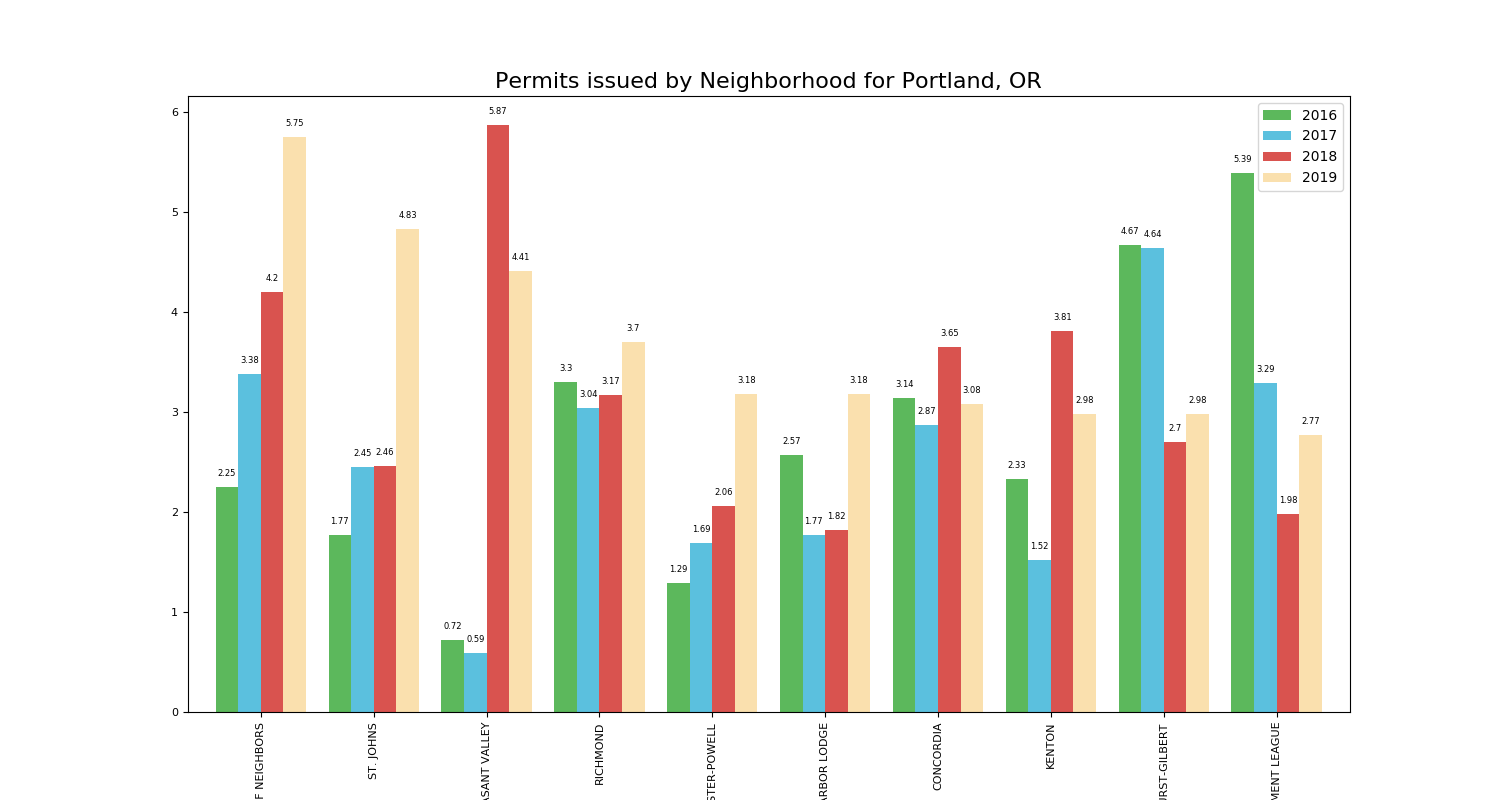

In [437]:
%matplotlib notebook
#since the df is sorted by 2019 volume of permits, we can graph the top ten neighborhoods based on 2019 levels
p_chart = viz_df.head(10).plot(kind='bar',
                               figsize=(15,8),
                               width=.8,
                               color=['#5cb85c', '#5bc0de', '#d9534f','#FAE0AE'],
                               fontsize=8)

plt.title('Permits issued by Neighborhood for Portland, OR',fontsize=16)
p_chart.legend(fontsize=10)

for p in p_chart.patches:
    p_chart.annotate(np.round(p.get_height(),decimals=2), 
                (p.get_x()+p.get_width()/2., p.get_height()), 
                ha='center', 
                va='center', 
                xytext=(0, 10), 
                textcoords='offset points',
                fontsize=6
               )
plt.show()



In [44]:
geo_missing = list(set([i.upper() for i in geo_hoods]).difference(set(pdx_hood_df['Neighborhood'])))

In [45]:
#we update the geo_json file, we need to find out the place of the unknown neighborhoods
missing_idx = {}
for i in geo_missing:
    for j in range(len(pdx_geo['features'])):        
        if pdx_geo['features'][j]['properties']['NAME'] == i:
            missing_idx[i] = j

In [46]:
missing_idx

{'MC UNCLAIMED #14': 53,
 'MC UNCLAIMED #13': 49,
 'MC UNCLAIMED #11': 44,
 'MC UNCLAIMED #5': 17}

In [47]:
#we want to remove unclaimed 14, 5, 13 and rename 11
#we pop in order of descending idx so as to not change the position
print('Length before {}'.format(len(pdx_geo['features'])))
pdx_geo['features'].pop(53)
pdx_geo['features'].pop(49)
pdx_geo['features'].pop(44)
pdx_geo['features'].pop(17)
print('Length after {}'.format(len(pdx_geo['features'])))

Length before 98
Length after 94


In [48]:
pdx_geo['features'][55]

{'type': 'Feature',
 'properties': {'OBJECTID': 60,
  'NAME': 'ARDENWALD-JOHNSON CREEK',
  'COMMPLAN': ' ',
  'SHARED': ' ',
  'COALIT': 'SEUL',
  'HORZ_VERT': 'HORZ',
  'MAPLABEL': 'Ardenwald-Johnson Creek',
  'ID': 3,
  'Shape_Length': 15320.697117256945,
  'Shape_Area': 5593594.225294752},
 'geometry': {'type': 'Polygon',
  'coordinates': [[[-122.61586200342884, 45.462557922401245],
    [-122.61589408765751, 45.46467663767927],
    [-122.61637366045848, 45.46467637054556],
    [-122.61641265003676, 45.46467633715384],
    [-122.61670312118218, 45.46467612546293],
    [-122.61699554706169, 45.464676048598996],
    [-122.61699656844617, 45.46470346634244],
    [-122.61735916712239, 45.464703123605],
    [-122.61735814573791, 45.46467570586134],
    [-122.61747511986263, 45.464675776425],
    [-122.61776753945391, 45.464675526302116],
    [-122.61786501295046, 45.4646754425078],
    [-122.6182549123265, 45.464675279329406],
    [-122.61844985842123, 45.46467511111077],
    [-122.618644

In [49]:
#check again (should be an empty set)
geo_hoods = [pdx_geo['features'][i]['properties']['NAME'] for i in range(len(pdx_geo['features']))]
set(geo_hoods).difference(set(pdx_hood_df['Neighborhood']))

set()

In [50]:
#Lets get the stat from the permits df that we want
p_grouped =permits_df.groupby('NBRHOOD')['NEW_UNITS'].sum().reset_index()
p_grouped.columns=['Neighborhood', 'New Units']

In [51]:
p_grouped.dtypes

Neighborhood    object
New Units        int64
dtype: object

In [52]:
new_units = []
for i in pdx_hood_df['Neighborhood']:
    if i in list(p_grouped['Neighborhood']):
        new_units.append(int(p_grouped[p_grouped['Neighborhood']==i]['New Units']))
    else:
        new_units.append(0)

In [53]:
pdx_hood_df['New Units'] = new_units

## Recap

Up to now, we have a cleaned Portland Geo_json file, extrated what we wanted from the building permit dataset, we have a dataset of portland by neighboorhood with the population, pop density, and projected new units

In [54]:
#get geocoords for portland
address = "Portland, OR"

geolocator = Nominatim(user_agent="extra_lime")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Portland, OR are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Portland, OR are 45.5202471, -122.6741949.


In [55]:
pdx_hood_df['Adjusted population'] = [int(i.replace(',','')) for i in pdx_hood_df['Adjusted population']]

Lets Create a map to show the neighborhoods and thier populations

In [56]:
pdx_map = folium.Map(location=[latitude, longitude], zoom_start=11)
pdx_map.choropleth(
    geo_data=pdx_geo,
    data=pdx_hood_df,
    columns=['Neighborhood', 'Adjusted population'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population in Portland, Oregon',
    reset=True
)
pdx_map

/home/extralime/.local/lib/python3.6/site-packages/folium/folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Lets look at the density of each neighborhood

In [57]:
pdx_hood_df['Adjusted population density (people per square mile, excluding parks and industrial tracts)']\
= [int(i.replace(',','')) for i in pdx_hood_df['Adjusted population density (people per square mile, excluding parks and industrial tracts)']]

In [58]:
pdx_map = folium.Map(location=[latitude, longitude], zoom_start=11)
pdx_map.choropleth(
    geo_data=pdx_geo,
    data=pdx_hood_df,
    columns=['Neighborhood', 'Adjusted population density (people per square mile, excluding parks and industrial tracts)'],
    key_on='feature.properties.NAME',
    fill_color='YlGnBu', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Population in Portland, Oregon',
    reset=True
)
pdx_map

This is a more interesting map, which conveys more meaningful data. However, it is based on 2018 data that has not been adjusted for new housing

lets correct that, also, lets take what we want from the pdx_hood_df and make a more concise DF

In [59]:
#first lets create a dataframe with basic information about each neighborhood
pdx_df = pdx_hood_df[['Neighborhood','Adjusted population','Median age', 'Latitude','Longitude',
 'Median household income ($)','Walk score','New Units','5-year median price change (2014–2018) (%)',
'Adjusted population density (people per square mile, excluding parks and industrial tracts)']].copy()

In [ ]:
from pandas.core.common import flatten

#find the center coords of each neighborhood
lng = []
lat = []
for i in pdx_df['Neighborhood']:
    for j in range(len(pdx_geo['features'])):
        if pdx_geo['features'][j]['properties']['NAME']==i:          
            cs = pdx_geo['features'][j]['geometry']['coordinates'][0]
            if len(cs) == 1:
                cs = list(flatten(pdx_geo['features'][54]['geometry']['coordinates']))
                lng.append(sum([cs[i] for i in range(len(cs)) if i%2 == 0])/len(cs)/2)
                lat.append(sum([cs[i] for i in range(len(cs)) if i%2 == 1])/len(cs)/2)    
            else: 
                lng.append(sum([cs[i][0] for i in range(len(cs))])/len(cs))
                lat.append(sum([cs[i][1] for i in range(len(cs))])/len(cs))            

In [ ]:
#get geocoords for portland
address = "BUCKMAN, PORTLAND, OR"

geolocator = Nominatim(user_agent="extra_lime")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Portland, OR are {}, {}.'.format(latitude, longitude))

In [ ]:
pdx_geo['features'][25]

In [ ]:
#add new data to DF
pdx_df['Latitude'] = lat
pdx_df['Longitude'] = lng

In [61]:
#lets adjust the names of the columns
pdx_df.columns = ['Neighborhood',
 'Adjusted population',
 'Median age',
 'Latitude',
 'Longitude',
 'Median household income ',
 'Walk score',
 'New Units',
 '5-year median price change',
 'Adjusted population density ']

In [62]:
#convert data to mathable types
pdx_df['5-year median price change'][85] = 0
for col in pdx_df.iloc[:,1:]:
    pdx_df[col] = pdx_df[col].astype(str)
    pdx_df[col] = [float(i.replace(',','').replace('%','')) for i in pdx_df[col]]
    

/home/extralime/.local/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [63]:
#Now we will incorporate the the new units, an assumption of 1.5 persons increase per new unit is given.
sq_miles = pd.Series(pdx_df['Adjusted population']/pdx_df['Adjusted population density '])
new_pop = pd.Series(pdx_df['Adjusted population']+ (pdx_df['New Units']*1.5))
pdx_df['new_density']=new_pop/sq_miles
pdx_df['pop_d_change'] = pdx_df['new_density']-pdx_df['Adjusted population density ']

In [64]:
#lets look at the map again and plot the change
pdx_map = folium.Map(location=[latitude, longitude], zoom_start=11)
pdx_map.choropleth(
    geo_data=pdx_geo,
    data=pdx_df,
    columns=['Neighborhood', 'pop_d_change'],
    key_on='feature.properties.NAME',
    fill_color='BuGn', 
    fill_opacity=0.7, 
    line_opacity=0.2,
    legend_name='Expected Population Density Change Portland, Oregon',
    reset=True
)
pdx_map

we need a rough estimate of the neighborhood size in sq meters. to do this we will divide population by population density, this should give us the area in miles, then we will multiply by 1609.4 to give meters

In [65]:
pdx_df['sq_meters'] = (pdx_df['Adjusted population']/pdx_df['Adjusted population density '])*1609.4
pdx_df.head()

Neighborhood  Adjusted population  Median age   Latitude  \
0                  ALAMEDA               5641.0        41.0  45.548631   
1              ARBOR LODGE               7245.0        36.0  45.571794   
2  ARDENWALD-JOHNSON CREEK               2015.0        41.0  45.458516   
3            ARGAY TERRACE               6035.0        40.0  45.552830   
4        ARLINGTON HEIGHTS               1804.0        52.0  45.519496   

    Longitude  Median household income   Walk score  New Units  \
0 -122.636481                  109616.0        65.0       30.0   
1 -122.690152                   75223.0        72.0      443.0   
2 -122.627539                   95630.0        54.0       10.0   
3 -122.523204                   51990.0        45.0       58.0   
4 -122.710667                  113665.0        40.0        1.0   

   5-year median price change  Adjusted population density    new_density  \
0                        26.0                        9544.0   9620.135437   
1                        33.0                        8654.0   9447.731263   
2                        34.0                       10273.0  10349.473945   
3                        52.0                        6942.0   7042.075228   
4                         9.0                        8934.0   8941.428492   

   pop_d_change    sq_meters  
0     76.135437   951.239040  
1    793.731263  1347.365727  
2     76.473945   315.676141  
3    100.075228  1399.125468  
4      7.428492   324.978464

In [66]:
#look at a map with the neighborhoods
# create map of Toronto using latitude and longitude values from geocoder
pn_map = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighborhood in zip(pdx_df['Latitude'], pdx_df['Longitude'], pdx_df['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=10,
        popup=label,
        color='green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.5,
        parse_html=False).add_to(pn_map)  
    
pn_map

Now we can use foursquare to get a list of venues in each neighborhood

In [67]:
#this cell retrieves id and key info for the foursquare api
with open('foursquare.json') as f:
    fs = f.read()
creds = json.loads(fs)
CLIENT_ID = creds['CLIENT_ID']
CLIENT_SECRET = creds['CLIENT_SECRET']
VERSION = creds["VERSION"]

In [ ]:
pdx_df[pdx_df['Neighborhood']=='PORTLAND DOWNTOWN']

In [ ]:
pdx_df.loc[0]['Latitude']

In [212]:
#function to get a more robust list of venues around a centroid
def get_5(name,start_lat,start_long,radius,limit):
    #adds a buffer to lat and long
    loc_lats = [start_lat,start_lat,start_lat,start_lat+.01,start_lat-.01]
    loc_longs = [start_long,start_long+.01,start_long-.01,start_long,start_long]
    v5_dfs=[]
    for i in range(5):
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        loc_lats[i], 
        loc_longs[i], 
        radius, 
        LIMIT)
        results = requests.get(url).json()

        venues = results['response']['groups'][0]['items']

        nearby_venues = json_normalize(venues) # flatten JSON
        ids = [nearby_venues['venue.categories'][i][0]['id'] for i in range(len(nearby_venues['venue.categories']))]
        # filter columns
        filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
        nearby_venues =nearby_venues.loc[:, filtered_columns]
        nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
        nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
        nearby_venues['id'] = ids

        v5_dfs.append(nearby_venues)
    #combine dfs
    all_df = pd.concat(v5_dfs)
    
    all_df = all_df.drop_duplicates(subset='id')
    n_l = (str(name+',')*all_df.shape[0]).split(',')[:-1]
    n_lat = ((str(start_lat)+',')*all_df.shape[0]).split(',')[:-1]
    n_long = ((str(start_long)+',')*all_df.shape[0]).split(',')[:-1]

    all_df['Neighborhood'] = n_l
    all_df['Neighborhood Lat'] = n_lat
    all_df['Neighborhood Long'] = n_long
    
    return all_df
    

In [192]:
n1 = pdx_df.loc[0]['Neighborhood']
start_lat = pdx_df.loc[0]['Latitude']
start_long = pdx_df.loc[0]['Longitude']

LIMIT=1000
radius=1500
test = get_5(n1,start_lat,start_long,1500,1000)

In [193]:
test

name  \
0                                       Guilder   
1                                  Garden Fever   
2                                         Lucca   
3                                    Mojo Sushi   
4                                    Kargi Gogo   
5                           Pine State Biscuits   
6                          Great Notion Brewing   
7                                      Urdaneta   
8                            Whole Foods Market   
9                                  Salt & Straw   
11                                   Grant Park   
12               Ampersand Gallery & Fine Books   
13                            Bollywood Theater   
14                  Brew Dr. Teahouse - Alberta   
15                               The Knock Back   
16                                     Sugar Me   
17                                         CORD   
18                   Petite Provence of Alberta   
21                                    Dar Salam   
22                          Back to Eden Bakery   
23                         Alberta Rose Theater   
24                                  La Sirenita   
25                               Sip Juice Cart   
26                                     Cruzroom   
27                                    Les Caves   
29                                    Hale Pele   
30                                    Verdigris   
32                               T.C. O'Leary's   
33                               Little Griddle   
34                Common Ground Wellness Center   
..                                          ...   
6                  Washington Park Amphitheater   
9                                    Oregon Zoo   
10                       Elephants Delicatessen   
12                        Liquor Store - Uptown   
14                         Tender Loving Empire   
16                                     Ringside   
17                                   Papa Haydn   
19                                  Tea Chai Té   
21                 Moonstruck Chocolate Company   
23                    The Meadow - NW 23rd Ave.   
26                              Williams-Sonoma   
27                                 Warby Parker   
28                              Providence Park   
30                                Fish And Rice   
33                   Portland Children's Museum   
34            Giraffe Exhibit At The Oregon Zoo   
35                Pharmaca Integrative Pharmacy   
36                    Oregon Culinary Institute   
39                                        Twist   
47                             Voicebox Karaoke   
54                          European Wax Center   
57                                 The Fireside   
68                                 Paper Source   
71     Predators Of The Serengeti At Oregon Zoo   
73                      Oregon Zoo Concert Lawn   
77            Will Leather Goods 'Family House'   
86                           Vista Ridge Tunnel   
92                                   Trimet 712   
93  Oregon Zoo Railway Washington Park Terminal   
95              Gold Medal Rose Garden Fountain   

                         categories        lat         lng  \
0                       Coffee Shop  45.548290 -122.641335   
1                     Garden Center  45.548010 -122.641359   
2                Italian Restaurant  45.548167 -122.641375   
3                  Sushi Restaurant  45.548351 -122.650162   
4               Dumpling Restaurant  45.559113 -122.634038   
5   Southern / Soul Food Restaurant  45.558981 -122.642697   
6                           Brewery  45.558881 -122.642771   
7                  Tapas Restaurant  45.559136 -122.634119   
8                     Grocery Store  45.548998 -122.651285   
9                    Ice Cream Shop  45.559148 -122.644141   
11                             Park  45.539932 -122.629707   
12                      Art Gallery  45.559002 -122.635513   
13                Indian Restaurant  45.559270 -122.644011   
14          

In [213]:
def get_hood_venues(name,lat,long,radius,limit):
    n_dfs = []
    for name,lat,long in zip(name,lat,long):
        print(name)
        n_dfs.append(get_5(name=name,start_lat=lat,start_long=long,radius=radius,limit=limit))
    all_df = pd.concat(n_dfs)
    return all_df
        

In [214]:
real_test = get_hood_venues(name=pdx_df['Neighborhood'],
                            lat=pdx_df['Latitude'],
                            long=pdx_df['Longitude'],
                            radius=1500,
                            limit=1000)

ALAMEDA
125
125
ARBOR LODGE
93
93
ARDENWALD-JOHNSON CREEK
90
90
ARGAY TERRACE
43
43
ARLINGTON HEIGHTS
111
111
ARNOLD CREEK
38
38
ASHCREEK
62
62
BEAUMONT-WILSHIRE
108
108
BOISE
94
94
BRENTWOOD-DARLINGTON
85
85
BRIDGETON
72
72
BRIDLEMILE
45
45
BROOKLYN ACTION CORPS
105
105
BUCKMAN COMMUNITY ASSOCIATION
118
118
CATHEDRAL PARK
62
62
CENTENNIAL COMMUNITY ASSOCIATION
51
51
COLLINS VIEW
54
54
CONCORDIA
90
90
CRESTON-KENILWORTH
108
108
CRESTWOOD
64
64
CULLY ASSOCIATION OF NEIGHBORS
74
74
PORTLAND DOWNTOWN
93
93
EAST COLUMBIA
63
63
EASTMORELAND
98
98
ELIOT
111
111
FAR SOUTHWEST
75
75
FOREST PARK
5
5
FOSTER-POWELL
91
91
GLENFAIR
49
49
GOOSE HOLLOW FOOTHILLS LEAGUE
121
121
GRANT PARK
120
120
HAYDEN ISLAND NEIGHBORHOOD NETWORK
86
86
HAYHURST
53
53
HAZELWOOD
81
81
HEALY HEIGHTS
70
70
HILLSDALE
85
85
HILLSIDE
116
116
HOLLYWOOD
110
110
HOMESTEAD
104
104
HOSFORD-ABERNETHY NEIGHBORHOOD DISTRICT ASSN.
109
109
HUMBOLDT
107
107
IRVINGTON COMMUNITY ASSOCIATION
129
129
KENTON
84
84
KERNS
115
115
KING
109
10

In [215]:
real_test.head()

name           categories        lat         lng  \
0       Guilder          Coffee Shop  45.548290 -122.641335   
1  Garden Fever        Garden Center  45.548010 -122.641359   
2         Lucca   Italian Restaurant  45.548167 -122.641375   
3    Mojo Sushi     Sushi Restaurant  45.548351 -122.650162   
4    Kargi Gogo  Dumpling Restaurant  45.559113 -122.634038   

                         id Neighborhood Neighborhood Lat Neighborhood Long  
0  4bf58dd8d48988d1e0931735      ALAMEDA       45.5486307      -122.6364806  
1  4eb1c0253b7b52c0e1adc2e9      ALAMEDA       45.5486307      -122.6364806  
2  4bf58dd8d48988d110941735      ALAMEDA       45.5486307      -122.6364806  
3  4bf58dd8d48988d1d2941735      ALAMEDA       45.5486307      -122.6364806  
4  4bf58dd8d48988d108941735      ALAMEDA       45.5486307      -122.6364806

In [216]:
#Check how many venues were returned by neighborhood
real_test.groupby('Neighborhood').count()

name  categories  lat  lng   id  \
Neighborhood                                                            
ALAMEDA                                125         125  125  125  125   
ARBOR LODGE                             93          93   93   93   93   
ARDENWALD-JOHNSON CREEK                 90          90   90   90   90   
ARGAY TERRACE                           43          43   43   43   43   
ARLINGTON HEIGHTS                      111         111  111  111  111   
ARNOLD CREEK                            38          38   38   38   38   
ASHCREEK                                62          62   62   62   62   
BEAUMONT-WILSHIRE                      108         108  108  108  108   
BOISE                                   94          94   94   94   94   
BRENTWOOD-DARLINGTON                    85          85   85   85   85   
BRIDGETON                               72          72   72   72   72   
BRIDLEMILE                              45          45   45   45   45   
BROOKLYN ACTION CORPS                  105         105  105  105  105   
BUCKMAN COMMUNITY ASSOCIATION          118         118  118  118  118   
CATHEDRAL PARK                          62          62   62   62   62   
CENTENNIAL COMMUNITY ASSOCIATION        51          51   51   51   51   
COLLINS VIEW                            54          54   54   54   54   
CONCORDIA                               90          90   90   90   90   
CRESTON-KENILWORTH                     108         108  108  108  108   
CRESTWOOD                               64          64   64   64   64   
CULLY ASSOCIATION OF NEIGHBORS          74          74   74   74   74   
EAST COLUMBIA                           63          63   63   63   63   
EASTMORELAND                            98          98   98   98   98   
ELIOT                                  111         111  111  111  111   
FAR SOUTHWEST                           75          75   75   75   75   
FOREST PARK                              5           5    5    5    5   
FOSTER-POWELL                           91          91   91   91   91   
GLENFAIR                                49          49   49   49   49   
GOOSE HOLLOW FOOTHILLS LEAGUE          121         121  121  121  121   
GRANT PARK                             120         120  120  120  120   
...                                    ...         ...  ...  ...  ...   
PEARL DISTRICT                         120         120  120  120  120   
PIEDMONT                               105         105  105  105  105   
PLEASANT VALLEY                         11          11   11   11   11   
PORTLAND DOWNTOWN                       93          93   93   93   93   
PORTSMOUTH                              55          55   55   55   55   
POWELLHURST-GILBERT                     48          48   48   48   48   
REED                                   110         110  110  110  110   
RICHMOND                                95          95   95   95   95   
ROSE CITY PARK                         104         104  104  104  104   
ROSEWAY                                 75          75   75   75   75   
RUSSELL                                 62          62   62   62   62   
SABIN COMMUNITY ASSOCIATION            108         108  108  108  108   
SELLWOOD-MORELAND IMPROVEMENT LEAGUE    81          81   81   81   81   
SOUTH BURLINGAME                        81          81   81   81   81   
SOUTH PORTLAND                         101         101  101  101  101   
SOUTH TABOR                            118         118  118  118  118   
SOUTHWEST HILLS RESIDENTIAL LEAGUE      38          38   38   38   38   
ST. JOHNS                               57          57   57   57   57   
SULLIVAN'S GULCH                       118         118  118  118  118   
SUMNER ASSOCIATION OF NEIGHBORS         71          71   71   71   71   
SUNDERLAND ASSOCIATION OF NEIGHBORS     59          59   59   59   59   
SUNNYSIDE                              104         104  104  104  104   
SYLVAN-HIGHLANDS       

In [218]:
#See how many unique categories there are for the given neighborhoods
print('There are {} uniques categories.'.format(len(real_test['categories'].unique())))

There are 371 uniques categories.


In [258]:
#Lets analyze each neighborhood
# one hot encoding
pdx_onehot = pd.get_dummies(real_test[['categories']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
pdx_onehot['Neighborhood'] = real_test['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [pdx_onehot.columns[245]] + list(pdx_onehot.columns[:-1])
pdx_onehot = pdx_onehot[fixed_columns]

pdx_onehot

Neighborhood  ATM  Accessories Store  Adult Boutique  African Restaurant  \
0       ALAMEDA    0                  0               0                   0   
1       ALAMEDA    0                  0               0                   0   
2       ALAMEDA    0                  0               0                   0   
3       ALAMEDA    0                  0               0                   0   
4       ALAMEDA    0                  0               0                   0   
5       ALAMEDA    0                  0               0                   0   
6       ALAMEDA    0                  0               0                   0   
7       ALAMEDA    0                  0               0                   0   
8       ALAMEDA    0                  0               0                   0   
9       ALAMEDA    0                  0               0                   0   
11      ALAMEDA    0                  0               0                   0   
12      ALAMEDA    0                  0               0                   0   
13      ALAMEDA    0                  0               0                   0   
14      ALAMEDA    0                  0               0                   0   
15      ALAMEDA    0                  0               0                   0   
16      ALAMEDA    0                  0               0                   0   
17      ALAMEDA    0                  0               0                   0   
18      ALAMEDA    0                  0               0                   0   
21      ALAMEDA    0                  0               0                   0   
22      ALAMEDA    0                  0               0                   0   
23      ALAMEDA    0                  0               0                   0   
24      ALAMEDA    0                  0               0                   0   
25      ALAMEDA    0                  0               0                   0   
26      ALAMEDA    0                  0               0                   0   
27      ALAMEDA    0                  0               0                   0   
29      ALAMEDA    0                  0               0                   0   
30      ALAMEDA    0                  0               0                   0   
32      ALAMEDA    0                  0               0                   0   
33      ALAMEDA    0                  0               0                   0   
34      ALAMEDA    0                  0               0                   0   
..          ...  ...                ...             ...                 ...   
40    WOODSTOCK    0                  0               0                   0   
56    WOODSTOCK    0                  0               0                   0   
66    WOODSTOCK    0                  0               0                   0   
67    WOODSTOCK    0                  0               0                   0   
83    WOODSTOCK    0                  0               0                   0   
4     WOODSTOCK    0                  0               0                   0   
18    WOODSTOCK    0                  0               0                   0   
28    WOODSTOCK    0                  0               0                   0   
65    WOODSTOCK    0                  0               0                   0   
69    WOODSTOCK    0                  0               0                   0   
71    WOODSTOCK    0                  0               0                   0   
77    WOODSTOCK    0                  0               0                   0   
78    WOODSTOCK    0                  0               0                   0   
81    WOODSTOCK    0                  0               0                   0   
83    WOODSTOCK    0                  0               0                   0   
4     WOODSTOCK    0                  0               0                   0   
11    WOODSTOCK    0                  0               0                   0   
17    WOODSTOCK    0                  0               0                   0   
26    WOODSTOCK    0                  0              

In [232]:
pdx_onehot.shape

(7837, 371)

In [243]:
pdx_onehot.drop(pdx_onehot.columns[246],axis=1,inplace=True)

In [247]:
pdx_onehot.insert(0,'Neighborhood', real_test['Neighborhood'])

In [248]:
#group by neighborhood and get mean frequency of each category
pdx_grouped = pdx_onehot.groupby('Neighborhood').mean().reset_index()
pdx_grouped

Neighborhood       ATM  Accessories Store  \
0                                ALAMEDA  0.008000           0.000000   
1                            ARBOR LODGE  0.010753           0.000000   
2                ARDENWALD-JOHNSON CREEK  0.011111           0.000000   
3                          ARGAY TERRACE  0.023256           0.000000   
4                      ARLINGTON HEIGHTS  0.000000           0.000000   
5                           ARNOLD CREEK  0.000000           0.000000   
6                               ASHCREEK  0.000000           0.000000   
7                      BEAUMONT-WILSHIRE  0.000000           0.009259   
8                                  BOISE  0.000000           0.000000   
9                   BRENTWOOD-DARLINGTON  0.011765           0.000000   
10                             BRIDGETON  0.000000           0.000000   
11                            BRIDLEMILE  0.000000           0.000000   
12                 BROOKLYN ACTION CORPS  0.000000           0.000000   
13         BUCKMAN COMMUNITY ASSOCIATION  0.000000           0.000000   
14                        CATHEDRAL PARK  0.016129           0.000000   
15      CENTENNIAL COMMUNITY ASSOCIATION  0.019608           0.000000   
16                          COLLINS VIEW  0.018519           0.000000   
17                             CONCORDIA  0.011111           0.011111   
18                    CRESTON-KENILWORTH  0.009259           0.009259   
19                             CRESTWOOD  0.015625           0.000000   
20        CULLY ASSOCIATION OF NEIGHBORS  0.013514           0.000000   
21                         EAST COLUMBIA  0.000000           0.000000   
22                          EASTMORELAND  0.010204           0.000000   
23                                 ELIOT  0.000000           0.000000   
24                         FAR SOUTHWEST  0.013333           0.000000   
25                           FOREST PARK  0.000000           0.000000   
26                         FOSTER-POWELL  0.010989           0.000000   
27                              GLENFAIR  0.020408           0.000000   
28         GOOSE HOLLOW FOOTHILLS LEAGUE  0.000000           0.000000   
29                            GRANT PARK  0.008333           0.008333   
..                                   ...       ...                ...   
64                        PEARL DISTRICT  0.000000           0.000000   
65                              PIEDMONT  0.009524           0.000000   
66                       PLEASANT VALLEY  0.000000           0.000000   
67                     PORTLAND DOWNTOWN  0.000000           0.000000   
68                            PORTSMOUTH  0.018182           0.000000   
69                   POWELLHURST-GILBERT  0.000000           0.000000   
70                                  REED  0.009091           0.000000   
71                              RICHMOND  0.000000           0.010526   
72                        ROSE CITY PARK  0.009615           0.000000   
73                               ROSEWAY  0.013333           0.000000   
74                               RUSSELL  0.016129           0.000000   
75           SABIN COMMUNITY ASSOCIATION  0.000000           0.000000   
76  SELLWOOD-MORELAND IMPROVEMENT LEAGUE  0.000000           0.000000   
77                      SOUTH BURLINGAME  0.012346           0.000000   
78                        SOUTH PORTLAND  0.009901           0.000000   
79                           SOUTH TABOR  0.008475           0.000000   
80    SOUTHWEST HILLS RESIDENTIAL LEAGUE  0.000000           0.000000   
81                             ST. JOHNS  0.017544           0.000000   
82                      SULLIVAN'S GULCH  0.008475           0.000000   
83       SUMNER ASSOCIATION OF NEIGHBORS  0.014085           0.000000   
84   SUNDERLAND ASSOCIATION OF NEIGHBORS  0.000000           0.000000   
85                             SUNNYSIDE  0.000000           0.009615   
86                      SYLVAN-HIGHLANDS  0.000000           0.000000   
87           

In [250]:
pdx_grouped.shape

(94, 370)

In [252]:
#Print out top categories for each neighborhood
num_top_venues = 5

for hood in pdx_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = pdx_grouped[pdx_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----ALAMEDA----
                             venue  freq
0                              ATM  0.01
1  Southern / Soul Food Restaurant  0.01
2                   Sandwich Place  0.01
3                   Discount Store  0.01
4                     Optical Shop  0.01


----ARBOR LODGE----
                  venue  freq
0                   ATM  0.01
1              Pharmacy  0.01
2     Fish & Chips Shop  0.01
3  Fast Food Restaurant  0.01
4           Pizza Place  0.01


----ARDENWALD-JOHNSON CREEK----
            venue  freq
0             ATM  0.01
1    Cupcake Shop  0.01
2  Farmers Market  0.01
3             Pub  0.01
4     Fabric Shop  0.01


----ARGAY TERRACE----
                    venue  freq
0                     ATM  0.02
1           Historic Site  0.02
2  Thrift / Vintage Store  0.02
3              Bike Trail  0.02
4         Thai Restaurant  0.02


----ARLINGTON HEIGHTS----
            venue  freq
0             Zoo  0.01
1      Donut Shop  0.01
2      Restaurant  0.01
3             Pub 

               venue  freq
0                ATM  0.01
1     Farmers Market  0.01
2        Fabric Shop  0.01
3  Electronics Store  0.01
4         Donut Shop  0.01


----LINNTON----
               venue  freq
0             Forest  0.09
1  Convenience Store  0.09
2                Bar  0.09
3     Sandwich Place  0.09
4        Gas Station  0.09


----LLOYD DISTRICT COMMUNITY ASSOCIATION----
                  venue  freq
0             Hotel Bar  0.01
1      Ramen Restaurant  0.01
2             Rock Club  0.01
3  Ethiopian Restaurant  0.01
4           Event Space  0.01


----MADISON SOUTH----
         venue  freq
0          ATM  0.01
1         Café  0.01
2         Food  0.01
3     Pharmacy  0.01
4  Pizza Place  0.01


----MAPLEWOOD----
                venue  freq
0   German Restaurant  0.02
1         Gas Station  0.02
2      Clothing Store  0.02
3        Noodle House  0.02
4  Frozen Yogurt Shop  0.02


----MARKHAM----
              venue  freq
0     Grocery Store  0.01
1  Greek Restaurant  0.

                  venue  freq
0            Smoke Shop  0.02
1  Mongolian Restaurant  0.02
2                 Trail  0.02
3    Persian Restaurant  0.02
4      Toy / Game Store  0.02


----WILKES COMMUNITY GROUP----
               venue  freq
0                Gym  0.03
1  Convenience Store  0.03
2      Garden Center  0.03
3            Brewery  0.03
4     Breakfast Spot  0.03


----WOODLAND PARK----
               venue  freq
0                ATM  0.01
1  Convenience Store  0.01
2         Eye Doctor  0.01
3                Pub  0.01
4  Electronics Store  0.01


----WOODLAWN----
                    venue  freq
0               Hotel Bar  0.01
1           Burrito Place  0.01
2      Seafood Restaurant  0.01
3          Cosmetics Shop  0.01
4  Gluten-free Restaurant  0.01


----WOODSTOCK----
                venue  freq
0                 ATM  0.01
1  Chinese Restaurant  0.01
2   Convenience Store  0.01
3      Shipping Store  0.01
4   Other Repair Shop  0.01




In [253]:
#function to sort in order of most popular

def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [255]:
#create dataframe for top 10 venues in each neighborhood
num_top_venues = 20

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = pdx_grouped['Neighborhood']

for ind in np.arange(pdx_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(pdx_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0                  ALAMEDA                   ATM     Convenience Store   
1              ARBOR LODGE                   ATM    Mexican Restaurant   
2  ARDENWALD-JOHNSON CREEK                   ATM         Bowling Alley   
3            ARGAY TERRACE                   ATM                Bakery   
4        ARLINGTON HEIGHTS                   Zoo                 Diner   

  3rd Most Common Venue    4th Most Common Venue    5th Most Common Venue  \
0           Coffee Shop  New American Restaurant              Music Venue   
1         Moving Target        Convenience Store  New American Restaurant   
2         Deli / Bodega             Dance Studio             Cupcake Shop   
3                   Bar   Thrift / Vintage Store          Thai Restaurant   
4        Clothing Store             Cocktail Bar             Optical Shop   

  6th Most Common Venue   7th Most Common Venue    8th Most Common Venue  \
0           Music Store           Movie Theater          Motorcycle Shop   
1                Office             Coffee Shop             Cocktail Bar   
2        Cosmetics Shop       Convenience Store               Comic Shop   
3           Coffee Shop  Furniture / Home Store         Sushi Restaurant   
4           Coffee Shop                  Office  New American Restaurant   

  9th Most Common Venue  ... 11th Most Common Venue  \
0            Comic Shop  ...           Noodle House   
1                  Park  ...              Pet Store   
2                  Park  ...            Coffee Shop   
3           Supermarket  ...                  Motel   
4                Museum  ...         Cooking School   

      12th Most Common Venue 13th Most Common Venue 14th Most Common Venue  \
0  Middle Eastern Restaurant     Mexican Restaurant       Cuban Restaurant   
1                   Pharmacy            Pizza Place             Playground   
2                  Pet Store               Pharmacy            Golf Course   
3                  Bookstore       Football Stadium         Farmers Market   
4             Cosmetics Shop               Creperie     Miscellaneous Shop   

  15th Most Common Venue 16th Most Common Venue    17th Most Common Venue  \
0         Massage Studio                 Lounge              Liquor Store   
1                   Pool                   Café                Print Shop   
2     Chinese Restaurant            Pizza Place                       Pub   
3   Fast Food Restaurant                    Spa                   Brewery   
4     Mexican Restaurant          Deli / Bodega  Mediterranean Restaurant   

          18th Most Common Venue 19th Most Common Venue 20th Most Common Venue  
0                 Lingerie Store           Cocktail Bar         Clothing Store  
1                            Pub              Racetrack            Record Shop  
2                           Café       Business Service               Bus Stop  
3                           Food                 Market         Sandwich Place  
4  Paper / Office Supplies Store                   Park  Performing Arts Venue  

[5 rows x 21 columns]

In [257]:
#Use silhouette score to determine best number of clusters
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

pdx_grouped_clustering = pdx_grouped.drop('Neighborhood', 1)

for i in range(2,10):
    kmeans = KMeans(n_clusters=i, random_state=0).fit(pdx_grouped_clustering)
    print('N.Clusters= {} -- Sil.Score {}'.format(i,silhouette_score(pdx_grouped_clustering,kmeans.labels_)))

N.Clusters= 2 -- Sil.Score 0.709041775853834
N.Clusters= 3 -- Sil.Score 0.5773814401671886
N.Clusters= 4 -- Sil.Score 0.5807546856855627
N.Clusters= 5 -- Sil.Score 0.11074674003884032
N.Clusters= 6 -- Sil.Score 0.06898567504557994
N.Clusters= 7 -- Sil.Score 0.07814136785586617
N.Clusters= 8 -- Sil.Score 0.0418370420253899
N.Clusters= 9 -- Sil.Score 0.04799374414200525


In [117]:
#Borrow function from foursquare lab
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
#new function
#Borrow function from foursquare lab
# function that extracts the category of the venue
def get_place_id(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0][0][0]

In [262]:
results['response']['groups']

[{'type': 'Recommended Places',
  'name': 'recommended',
  'items': [{'reasons': {'count': 0,
     'items': [{'summary': 'This spot is popular',
       'type': 'general',
       'reasonName': 'globalInteractionReason'}]},
    'venue': {'id': '49e63ed3f964a5202c641fe3',
     'name': 'Portland Japanese Garden',
     'location': {'address': '611 SW Kingston Ave',
      'crossStreet': 'at SW Fairview Blvd',
      'lat': 45.51945662953895,
      'lng': -122.70693715666339,
      'labeledLatLngs': [{'label': 'display',
        'lat': 45.51945662953895,
        'lng': -122.70693715666339}],
      'distance': 290,
      'postalCode': '97205',
      'cc': 'US',
      'city': 'Portland',
      'state': 'OR',
      'country': 'United States',
      'formattedAddress': ['611 SW Kingston Ave (at SW Fairview Blvd)',
       'Portland, OR 97205',
       'United States']},
     'categories': [{'id': '4bf58dd8d48988d15a941735',
       'name': 'Garden',
       'pluralName': 'Gardens',
       'shortName':

In [ ]:
len(results['response']['groups'][0]['items'])

In [136]:
venues = results['response']['groups'][0]['items']
    
c_venues = json_normalize(venues) # flatten JSON
ids = [ c_venues['venue.categories'][i][0]['id'] for i in range(len(c_venues['venue.categories']))]

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
c_venues =c_venues.loc[:, filtered_columns]

# filter the category for each row
c_venues['venue.categories'] = c_venues.apply(get_category_type, axis=1)
# clean columns
c_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
c_venues['id'] = ids

c_venues.head()

name        categories        lat         lng  \
0        Portland Japanese Garden            Garden  45.519457 -122.706937   
1                 Washington Park              Park  45.517835 -122.705784   
2  International Rose Test Garden  Botanical Garden  45.519075 -122.705616   
3                  Hoyt Arboretum              Park  45.517493 -122.717714   
4              Shakespeare Garden            Garden  45.518558 -122.704685   

                         id  
0  4bf58dd8d48988d15a941735  
1  4bf58dd8d48988d163941735  
2  52e81612bcbc57f1066b7a22  
3  4bf58dd8d48988d163941735  
4  4bf58dd8d48988d15a941735

In [134]:
ids = [ c_venues['venue.categories'][i][0]['id'] for i in range(len(c_venues['venue.categories']))]

KeyError: 'venue.categories'

In [259]:
c_venues

name               categories  \
0                      Portland Japanese Garden                   Garden   
1                               Washington Park                     Park   
2                International Rose Test Garden         Botanical Garden   
3                                Hoyt Arboretum                     Park   
4                            Shakespeare Garden                   Garden   
5                               Pittock Mansion                   Museum   
6                  Washington Park Amphitheater             Amphitheater   
7                  Forest Park - Wildwood Trail                    Trail   
8                                Zupan's Market            Grocery Store   
9                                    Oregon Zoo                      Zoo   
10                       Elephants Delicatessen            Deli / Bodega   
11                             Elephant Exhibit                      Zoo   
12                        Liquor Store - Uptown             Liquor Store   
13                                   Umami Cafe                     Café   
14                         Tender Loving Empire       Miscellaneous Shop   
15                    Vietnam Veterans Memorial                   Garden   
16                                     Ringside               Steakhouse   
17                                   Papa Haydn             Dessert Shop   
18                                 Salt & Straw           Ice Cream Shop   
19                                  Tea Chai Té                 Tea Room   
20                Hoyt Arboritum Visitor Center                     Park   
21                 Moonstruck Chocolate Company              Candy Store   
22                                         LUSH           Cosmetics Shop   
23                    The Meadow - NW 23rd Ave.             Gourmet Shop   
24                  Rose Garden Children's Park               Playground   
25                         Ken's Artisan Bakery                   Bakery   
26                              Williams-Sonoma     Kitchen Supply Store   
27                                 Warby Parker             Optical Shop   
28                              Providence Park           Soccer Stadium   
29                              Bamboo Sushi NW         Sushi Restaurant   
..                                          ...                      ...   
70                                Kells Brewery                  Brewery   
71     Predators Of The Serengeti At Oregon Zoo           Scenic Lookout   
72                       Pepino's Mexican Grill       Mexican Restaurant   
73                      Oregon Zoo Concert Lawn    Performing Arts Venue   
74                        Jo Bar and Rotisserie  New American Restaurant   
75                   Washington Park Playground               Playground   
76                                  Taste On 23                 Wine Bar   
77            Will Leather Goods 'Family House'      Leather Goods Store   
78                           Dutch Bros. Coffee              Coffee Shop   
79                   Spielman's Coffee & Bagels              Coffee Shop   
80                  Schmizza Pub & Grub on 21st              Pizza Place   
81               The Bat Cave At The Oregon Zoo              Zoo Exhibit   
82                            Vista Spring Cafe                     Café   
83                               Witch's Castle           Scenic Lookout   
84                           Polar Bear Exhibit              Zoo Exhibit   
85                                 KeyBank Club           Soccer Stadium   
86                           Vista Ridge Tunnel                   Tunnel   
87          Portland Japanese Garden Gift Store                Gift Shop   
88                  Ellie M Hill Bonsai Terrace         Botanical Garden   
89                                  Rock Garden                   Garden   
90                    The Sand and Stone Garden                   Garden   
91             

In [132]:
c_venues.head()

name        categories        lat         lng  \
0        Portland Japanese Garden            Garden  45.519457 -122.706937   
1                 Washington Park              Park  45.517835 -122.705784   
2  International Rose Test Garden  Botanical Garden  45.519075 -122.705616   
3                  Hoyt Arboretum              Park  45.517493 -122.717714   
4              Shakespeare Garden            Garden  45.518558 -122.704685   

                        ids  
0  4bf58dd8d48988d15a941735  
1  4bf58dd8d48988d163941735  
2  52e81612bcbc57f1066b7a22  
3  4bf58dd8d48988d163941735  
4  4bf58dd8d48988d15a941735

In [127]:
ids = [ c_venues['venue.categories'][i][0]['id'] for i in range(len(c_venues['venue.categories']))]

In [120]:
c_venues['venue.categories'][0][0]['id']

'4bf58dd8d48988d15a941735'

In [ ]:
#lets see how many venues were retireved
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

In [72]:
type(nearby_venues)

pandas.core.frame.DataFrame